# Text Generation (RNN)

## Load Libraries and Data

In [1]:
import logging
import absl.logging
from pathlib import Path
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Restrict tensorflow output to errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
absl.logging.set_verbosity(absl.logging.ERROR)

# Make this notebook's output stable across runs
random_state = 1000
np.random.seed(random_state)
tf.random.set_seed(random_state)

# Plot formatting
%matplotlib inline
sns.set()
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Data Source

Load Shakespeare text from the [char-rnn project](https://github.com/karpathy/char-rnn/).

In [2]:
shakespeare_url = 'https://homl.info/shakespeare'
filepath = tf.keras.utils.get_file('shakespeare.txt', shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [3]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [4]:
# There are 39 distinct characters in the text
''.join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [5]:
# Encode letters numerically and convert all text to lowercase
text_vec_layer = tf.keras.layers.TextVectorization(split='character',
                                                   standardize='lower')
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]

encoded -= 2  # Drop extraneous tokens 0 (pad) and 1 (unknown)

n_tokens = text_vec_layer.vocabulary_size() - 2
dataset_size = len(encoded)
print(dataset_size)

1115394


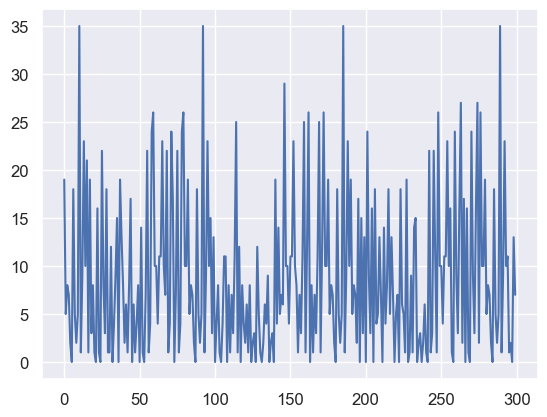

In [6]:
plt.plot(encoded[:300])
plt.show()

In [7]:
vocab = text_vec_layer.get_vocabulary()[2:]
for i, v in enumerate(vocab):
    print(f'{i}: {repr(v)}')

0: ' '
1: 'e'
2: 't'
3: 'o'
4: 'a'
5: 'i'
6: 'h'
7: 's'
8: 'r'
9: 'n'
10: '\n'
11: 'l'
12: 'd'
13: 'u'
14: 'm'
15: 'y'
16: 'w'
17: ','
18: 'c'
19: 'f'
20: 'g'
21: 'b'
22: 'p'
23: ':'
24: 'k'
25: 'v'
26: '.'
27: "'"
28: ';'
29: '?'
30: '!'
31: '-'
32: 'j'
33: 'q'
34: 'x'
35: 'z'
36: '3'
37: '&'
38: '$'


In [8]:
vocab[35]

'z'

In [9]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [10]:
list(to_dataset(text_vec_layer(['To be'])[0], length=4))

[(<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 4,  5,  2, 23]])>,
  <tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 5,  2, 23,  3]])>)]

In [11]:
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000], length=length,
                       shuffle=True, seed=random_state)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

## Training the RNN Model

In [12]:
# NOTE: This takes a long time to run. The code in the
# subsequent cell will download a pre-trained model

# tf.random.set_seed(random_state)

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
#     tf.keras.layers.GRU(128, return_sequences=True),
#     tf.keras.layers.Dense(n_tokens, activation='softmax')
# ])
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer='nadam', metrics=['accuracy'])
# model_ckpt = tf.keras.callbacks.ModelCheckpoint('my_shakespeare_model', 
#                                                 monitor='val_accuracy',
#                                                 save_best_only=True)
# history = model.fit(train_set, validation_data=valid_set, epochs=10,
#                     callbacks=[model_ckpt])

# shakespeare_model = tf.keras.Sequential([
#     text_vec_layer,
#     # Removed the padding and unknown tokens
#     tf.keras.layers.Lambda(lambda X: X - 2),  
#     model
# ])

In [13]:
# Download a pretrained version of the above model
url = 'https://github.com/ageron/data/raw/main/shakespeare_model.tgz'
path = tf.keras.utils.get_file('shakespeare_model.tgz', url, extract=True)
model_path = Path(path).with_name('shakespeare_model')
shakespeare_model = tf.keras.models.load_model(model_path)

In [14]:
# Choose the most probable next character in the sequence
# 'To be or not to b'
y_proba = shakespeare_model.predict(['To be or n'])[0, -1]
y_pred = tf.argmax(y_proba)
text_vec_layer.get_vocabulary()[y_pred + 2]

1/1 [==============================] - 0s 222ms/step


'o'

In [15]:
# List the probabilities of each possible character for the sequence
# 'To be or not to b'
shakespeare_model.predict(['To be or not'])[0, -1]

1/1 [==============================] - 0s 14ms/step


array([7.66933441e-01, 4.34516603e-03, 6.61389495e-05, 4.08260268e-04,
       1.43223544e-04, 1.29511137e-03, 5.54457195e-02, 1.86481717e-04,
       2.55599116e-06, 1.58530456e-05, 8.54146481e-02, 1.74992325e-04,
       2.82609632e-04, 4.73438675e-04, 8.82216864e-06, 9.35263600e-08,
       2.25399839e-04, 2.60936841e-02, 1.13426184e-03, 2.90157695e-05,
       1.72068297e-08, 1.10713734e-06, 1.43064142e-07, 9.60936770e-03,
       1.16685135e-06, 1.59692138e-11, 2.59643905e-02, 3.11259821e-04,
       8.38700496e-03, 9.34743043e-03, 2.17941683e-03, 1.51985022e-03,
       1.04705355e-10, 1.00136477e-09, 4.21948254e-09, 2.86262991e-09,
       8.73140451e-15, 2.51442475e-18, 1.58430242e-20], dtype=float32)

## Generating Text from the RNN Model

In [16]:
# Use probabilities to generate more interesting
# (less repetitive) sequences of text

# Example of how random draws work
log_probas = tf.math.log([[0.5, 0.4, 0.1]]) 
tf.random.set_seed(random_state)
tf.random.categorical(log_probas, num_samples=8)

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 1, 0, 0, 1, 0, 0, 0]])>

In [17]:
# What happens when we divide log probabilities by a low "temperature"?
log_probas = tf.math.log([[0.5, 0.4, 0.1]])
rescaled_log_probas = log_probas / 0.01
print(tf.math.exp(rescaled_log_probas))
tf.random.categorical(rescaled_log_probas, num_samples=8)

tf.Tensor([[7.8885926e-31 0.0000000e+00 0.0000000e+00]], shape=(1, 3), dtype=float32)


<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0]])>

In [18]:
# What happens when we divide log probabilities by a high "temperature"?
log_probas = tf.math.log([[0.5, 0.4, 0.1]])
rescaled_log_probas = log_probas / 100
print(tf.math.exp(rescaled_log_probas))
tf.random.categorical(rescaled_log_probas, num_samples=8)

tf.Tensor([[0.9930925  0.99087894 0.9772372 ]], shape=(1, 3), dtype=float32)


<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[1, 2, 2, 2, 0, 0, 2, 0]])>

In [19]:
def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict([text])[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]


def extend_text(text, n_chars=15, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [20]:
tf.random.set_seed(random_state)

In [21]:
print(extend_text('To be or not to be', temperature=0.01))

1/1 [==============================] - 0s 15ms/step
To be or not to be the duke
as it


In [22]:
print(extend_text("To be or not to be", temperature=1))

1/1 [==============================] - 0s 15ms/step
To be or not to be worse
and from


In [23]:
print(extend_text("To be or not to be", temperature=100))

1/1 [==============================] - 0s 15ms/step
To be or not to bec!yl'ed'ra&zyg 


In [24]:
print(extend_text('Uneasy lies the head that wears',
                  n_chars=8, temperature=0.01))

1/1 [==============================] - 0s 15ms/step
Uneasy lies the head that wears the law


## Using a Stateful RNN

In [25]:
def to_dataset_for_stateful_rnn(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(length + 1)).batch(1)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)


stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000],
                                                 length)
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)

In [26]:
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

[(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 4, 5]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[4, 5, 6]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[7, 8, 9]], dtype=int32)>)]

In [27]:
tf.random.set_seed(random_state)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16,
                              batch_input_shape=[1, None]),
    tf.keras.layers.GRU(128, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

In [28]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()
        

model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    'my_stateful_shakespeare_model',
    monitor='val_accuracy',
    save_best_only=True)


model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(stateful_train_set, validation_data=stateful_valid_set,
                    epochs=5, callbacks=[ResetStatesCallback(), model_ckpt])

Epoch 1/5
9999/9999 [==============================] - 111s 11ms/step - loss: 1.8651 - accuracy: 0.4502 - val_loss: 1.7091 - val_accuracy: 0.4949
Epoch 2/5
9999/9999 [==============================] - 112s 11ms/step - loss: 1.5610 - accuracy: 0.5288 - val_loss: 1.6197 - val_accuracy: 0.5169
Epoch 3/5
9999/9999 [==============================] - 110s 11ms/step - loss: 1.4829 - accuracy: 0.5491 - val_loss: 1.5836 - val_accuracy: 0.5291
Epoch 4/5
9999/9999 [==============================] - 125s 12ms/step - loss: 1.4439 - accuracy: 0.5593 - val_loss: 1.5678 - val_accuracy: 0.5339
Epoch 5/5
9999/9999 [==============================] - 108s 11ms/step - loss: 1.4200 - accuracy: 0.5651 - val_loss: 1.5577 - val_accuracy: 0.5358


In [32]:
# model.save('stateful_rnn.h5')

In [36]:
# model = keras.models.load_model('stateful_rnn.h5')

In [29]:
stateless_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

stateless_model.build(tf.TensorShape([None, None]))
stateless_model.set_weights(model.get_weights())

shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),
    stateless_model
])

In [30]:
tf.random.set_seed(random_state)
print(extend_text('to be', temperature=0.01))

1/1 [==============================] - 0s 17ms/step
to be all:
i will be


In [31]:
tf.random.set_seed(random_state)
print(extend_text('to be', temperature=1.1))

1/1 [==============================] - 0s 18ms/step
to be in
with for's 
